In [88]:
import json
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm import tqdm as progress
from glob import glob
from skimage.transform import resize as sk_resize
from scipy.ndimage import zoom
from PIL import Image

In [90]:
def getImageSeq(group, color):
    pattern = f"../data/DAVIS_SEG/segmented_objects/{group}/*_object_{color}.png"
    
    # Load all frames first
    frames = []
    for fn in sorted(glob(pattern)):
        frame = mpimg.imread(fn)
        frames.append(frame)
    
    if not frames:
        return frames
    
    # Find global bounding box across all frames
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = 0, 0
    
    for frame in frames:
        # Check for alpha channel (transparency)
        if frame.shape[2] == 4:  # RGBA
            # Find non-transparent pixels
            non_transparent = np.where(frame[:,:,3] > 0)
        else:  # RGB or other format without transparency
            # Assume any non-black pixel is part of the object
            non_transparent = np.where(np.sum(frame, axis=2) > 0)
        
        if len(non_transparent[0]) > 0:  # If there are non-transparent pixels
            y_indices, x_indices = non_transparent
            min_x = min(min_x, np.min(x_indices))
            min_y = min(min_y, np.min(y_indices))
            max_x = max(max_x, np.max(x_indices))
            max_y = max(max_y, np.max(y_indices))
    
    # Handle case where no non-transparent pixels were found
    if min_x == float('inf'):
        return frames
    
    # Crop all frames to the bounding box
    cropped_frames = []
    for frame in frames:
        cropped = frame[min_y:max_y+1, min_x:max_x+1]
        cropped_frames.append(cropped)
    
    return cropped_frames

In [91]:
import numpy as np
from scipy.ndimage import zoom

def blit_transparent_image(canvas, stamp, min_x, min_y, max_x, max_y):
    """
    Blits a transparent stamp image onto a canvas image within specified coordinates.
    
    Parameters:
    -----------
    canvas : numpy.ndarray
        The target image with shape (H, W, C) where C is either 3 (RGB) or 4 (RGBA).
    stamp : numpy.ndarray
        The source image with shape (N, N, 4) including alpha channel.
    min_x, min_y : int
        The top-left corner coordinates on the canvas where the stamp should be placed.
    max_x, max_y : int
        The bottom-right corner coordinates on the canvas where the stamp should be placed.
    
    Returns:
    --------
    numpy.ndarray
        The modified canvas with the stamp blitted onto it.
    """
    # Make sure canvas has an alpha channel
    if canvas.shape[2] == 3:
        new_canvas = np.zeros((canvas.shape[0], canvas.shape[1], 4), dtype=np.uint8)
        new_canvas[:, :, :3] = canvas
        new_canvas[:, :, 3] = 255  # Fully opaque
        canvas = new_canvas
    
    # Make sure our coordinates are within the canvas boundaries
    min_x = max(0, min_x)
    max_x = min(canvas.shape[1], max_x)
    min_y = max(0, min_y)
    max_y = min(canvas.shape[0], max_y)
    
    # Check if we have a valid region to blit into
    if min_x >= max_x or min_y >= max_y:
        print("Warning: Invalid blitting region, coordinates result in empty area")
        return canvas
    
    # Calculate the scale factors
    target_width = max_x - min_x
    target_height = max_y - min_y
    
    # Check if we need to actually scale the stamp
    if stamp.shape[0] != target_height or stamp.shape[1] != target_width:
        # Calculate zoom factors
        zoom_y = target_height / stamp.shape[0]
        zoom_x = target_width / stamp.shape[1]
        
        # Scale the stamp to fit the target region
        scaled_stamp = zoom(stamp, (zoom_y, zoom_x, 1), order=1)
    else:
        scaled_stamp = stamp
    
    # Get the region where we'll blit the stamp
    region_height = max_y - min_y
    region_width = max_x - min_x
    
    # Ensure the scaled stamp has the right dimensions by cropping if necessary
    if scaled_stamp.shape[0] > region_height or scaled_stamp.shape[1] > region_width:
        scaled_stamp = scaled_stamp[:region_height, :region_width, :]
    
    # Handle case where scaled stamp is smaller than region
    if scaled_stamp.shape[0] < region_height or scaled_stamp.shape[1] < region_width:
        temp_stamp = np.zeros((region_height, region_width, 4), dtype=scaled_stamp.dtype)
        temp_stamp[:scaled_stamp.shape[0], :scaled_stamp.shape[1], :] = scaled_stamp
        scaled_stamp = temp_stamp
    
    # Sanity check to ensure shapes match before blending
    if (scaled_stamp.shape[0] != region_height or 
        scaled_stamp.shape[1] != region_width or
        min_y + region_height > canvas.shape[0] or
        min_x + region_width > canvas.shape[1]):
        print(f"Shape mismatch: stamp={scaled_stamp.shape}, region={region_height}x{region_width}")
        print(f"Canvas shape: {canvas.shape}, region: {min_y}:{max_y}, {min_x}:{max_x}")
        return canvas  # Return unmodified canvas if shapes don't match
    
    # Extract alpha channels
    alpha_stamp = scaled_stamp[:, :, 3] / 255.0
    alpha_canvas = canvas[min_y:max_y, min_x:max_x, 3] / 255.0
    
    # Calculate the resulting alpha
    alpha_result = alpha_stamp + alpha_canvas * (1 - alpha_stamp)
    
    # Prevent division by zero
    mask = alpha_result > 0
    
    # Initialize the blended result for RGB channels
    blended = np.zeros((region_height, region_width, 3), dtype=np.float32)
    
    # Blend RGB channels where alpha is non-zero
    for c in range(3):
        blended[:, :, c][mask] = (
            (scaled_stamp[:, :, c][mask] * alpha_stamp[mask] + 
             canvas[min_y:max_y, min_x:max_x, c][mask] * alpha_canvas[mask] * (1 - alpha_stamp[mask])) 
            / alpha_result[mask]
        )
    
    # Update the canvas
    canvas[min_y:max_y, min_x:max_x, :3][mask] = blended[mask]
    canvas[min_y:max_y, min_x:max_x, 3] = (alpha_result * 255).astype(np.uint8)
    
    return canvas

In [92]:
with open("../tiling.json", "r") as f:
    tilingJSON = json.load(f)

In [93]:
minF = tilingJSON[0]["minF"]
maxF = tilingJSON[0]["maxF"]
minX = tilingJSON[0]["minX"]
maxX = tilingJSON[0]["maxX"]
minY = tilingJSON[0]["minY"]
maxY = tilingJSON[0]["maxY"]
for tile in tilingJSON:
    minF = min(minF, tile["minF"])
    maxF = max(maxF, tile["maxF"])

    minX = min(minX, tile["minX"])
    maxX = max(maxX, tile["maxX"])

    minY = min(minY, tile["minY"])
    maxY = max(maxY, tile["maxY"])
    
minF = max(0, minF)

In [99]:
frames = []

scaleFac = 10.0

for f in range(int(minF), int(maxF)):
    canvas = np.zeros((int(maxY*scaleFac)+1, int(maxX*scaleFac)+1, 4))
    print(f"Processing frame {f} of {int(maxF)}...")
    for tile in progress(tilingJSON):
        if (tile["minF"] <= f) and (tile["maxF"] >= f):
            seq = getImageSeq(tile["group"], tile["color"])
            tileFrame = int( ((f - tile["minF"]) / (tile["maxF"] - tile["minF"])) * len(seq) )
            tileImg = seq[tileFrame]
            blit_transparent_image(canvas, tileImg, int(tile["minX"]*scaleFac), int(tile["minY"]*scaleFac), int(tile["maxX"]*scaleFac), int(tile["maxY"]*scaleFac))
    Image.fromarray((canvas * 255).astype(np.uint8)).save(f"frame__{f:04}.png")

Processing frame 0 of 80...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:02<00:00, 54.81it/s]


Processing frame 1 of 80...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:07<00:00, 21.66it/s]


Processing frame 2 of 80...


100%|████████████████████████████████████████████| 164/164 [00:08<00:00, 19.17it/s]


Processing frame 3 of 80...


100%|████████████████████████████████████████████| 164/164 [00:11<00:00, 14.70it/s]


Processing frame 4 of 80...


100%|████████████████████████████████████████████| 164/164 [00:14<00:00, 11.50it/s]


Processing frame 5 of 80...


100%|████████████████████████████████████████████| 164/164 [00:17<00:00,  9.13it/s]


Processing frame 6 of 80...


100%|████████████████████████████████████████████| 164/164 [00:20<00:00,  8.12it/s]


Processing frame 7 of 80...


100%|████████████████████████████████████████████| 164/164 [00:23<00:00,  7.09it/s]


Processing frame 8 of 80...


100%|████████████████████████████████████████████| 164/164 [00:25<00:00,  6.32it/s]


Processing frame 9 of 80...


100%|████████████████████████████████████████████| 164/164 [00:30<00:00,  5.30it/s]


Processing frame 10 of 80...


100%|████████████████████████████████████████████| 164/164 [00:32<00:00,  5.06it/s]


Processing frame 11 of 80...


100%|████████████████████████████████████████████| 164/164 [00:31<00:00,  5.14it/s]


Processing frame 12 of 80...


100%|████████████████████████████████████████████| 164/164 [00:39<00:00,  4.13it/s]


Processing frame 13 of 80...


100%|████████████████████████████████████████████| 164/164 [00:40<00:00,  4.03it/s]


Processing frame 14 of 80...


100%|████████████████████████████████████████████| 164/164 [00:43<00:00,  3.81it/s]


Processing frame 15 of 80...


100%|████████████████████████████████████████████| 164/164 [00:39<00:00,  4.16it/s]


Processing frame 16 of 80...


100%|████████████████████████████████████████████| 164/164 [00:36<00:00,  4.44it/s]


Processing frame 17 of 80...


100%|████████████████████████████████████████████| 164/164 [00:36<00:00,  4.43it/s]


Processing frame 18 of 80...


100%|████████████████████████████████████████████| 164/164 [00:38<00:00,  4.21it/s]


Processing frame 19 of 80...


100%|████████████████████████████████████████████| 164/164 [00:40<00:00,  4.02it/s]


Processing frame 20 of 80...


100%|████████████████████████████████████████████| 164/164 [00:41<00:00,  3.98it/s]


Processing frame 21 of 80...


100%|████████████████████████████████████████████| 164/164 [00:48<00:00,  3.41it/s]


Processing frame 22 of 80...


100%|████████████████████████████████████████████| 164/164 [00:48<00:00,  3.38it/s]


Processing frame 23 of 80...


100%|████████████████████████████████████████████| 164/164 [00:52<00:00,  3.10it/s]


Processing frame 24 of 80...


100%|████████████████████████████████████████████| 164/164 [00:44<00:00,  3.68it/s]


Processing frame 25 of 80...


100%|████████████████████████████████████████████| 164/164 [00:45<00:00,  3.60it/s]


Processing frame 26 of 80...


100%|████████████████████████████████████████████| 164/164 [00:41<00:00,  3.94it/s]


Processing frame 27 of 80...


100%|████████████████████████████████████████████| 164/164 [00:42<00:00,  3.83it/s]


Processing frame 28 of 80...


100%|████████████████████████████████████████████| 164/164 [00:40<00:00,  4.03it/s]


Processing frame 29 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:43<00:00,  3.75it/s]


Processing frame 30 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:43<00:00,  3.73it/s]


Processing frame 31 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:44<00:00,  3.68it/s]


Processing frame 32 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:44<00:00,  3.70it/s]


Processing frame 33 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:39<00:00,  4.12it/s]


Processing frame 34 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:41<00:00,  3.99it/s]


Processing frame 35 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:39<00:00,  4.13it/s]


Processing frame 36 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:39<00:00,  4.14it/s]


Processing frame 37 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:44<00:00,  3.72it/s]


Processing frame 38 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:39<00:00,  4.18it/s]


Processing frame 39 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:42<00:00,  3.84it/s]


Processing frame 40 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:42<00:00,  3.87it/s]


Processing frame 41 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:44<00:00,  3.67it/s]


Processing frame 42 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:41<00:00,  3.95it/s]


Processing frame 43 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:43<00:00,  3.78it/s]


Processing frame 44 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:41<00:00,  3.98it/s]


Processing frame 45 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:41<00:00,  3.95it/s]


Processing frame 46 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:38<00:00,  4.27it/s]


Processing frame 47 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:36<00:00,  4.52it/s]


Processing frame 48 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:35<00:00,  4.57it/s]


Processing frame 49 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:34<00:00,  4.76it/s]


Processing frame 50 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:32<00:00,  5.00it/s]


Processing frame 51 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:32<00:00,  5.03it/s]


Processing frame 52 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:36<00:00,  4.50it/s]


Processing frame 53 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:37<00:00,  4.43it/s]


Processing frame 54 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:32<00:00,  5.01it/s]


Processing frame 55 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:32<00:00,  5.04it/s]


Processing frame 56 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:31<00:00,  5.22it/s]


Processing frame 57 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:30<00:00,  5.34it/s]


Processing frame 58 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:30<00:00,  5.46it/s]


Processing frame 59 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:29<00:00,  5.54it/s]


Processing frame 60 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:30<00:00,  5.42it/s]


Processing frame 61 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:27<00:00,  5.91it/s]


Processing frame 62 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:28<00:00,  5.85it/s]


Processing frame 63 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:25<00:00,  6.32it/s]


Processing frame 64 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:23<00:00,  6.84it/s]


Processing frame 65 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:24<00:00,  6.56it/s]


Processing frame 66 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:25<00:00,  6.44it/s]


Processing frame 67 of 80...


100%|██████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:25<00:00,  6.52it/s]


Processing frame 68 of 80...


100%|██████████| 164/164 [00:21<00:00,  7.72it/s]


Processing frame 69 of 80...


100%|███████████████████████████████████████████████| 164/164 [00:19<00:00,  8.46it/s]


Processing frame 70 of 80...


100%|███████████████████████████████████████████████| 164/164 [00:18<00:00,  8.65it/s]


Processing frame 71 of 80...


100%|███████████████████████████████████████████████| 164/164 [00:17<00:00,  9.29it/s]


Processing frame 72 of 80...


100%|███████████████████████████████████████████████| 164/164 [00:15<00:00, 10.27it/s]


Processing frame 73 of 80...


100%|███████████████████████████████████████████████| 164/164 [00:14<00:00, 11.04it/s]


Processing frame 74 of 80...


100%|███████████████████████████████████████████████| 164/164 [00:14<00:00, 11.08it/s]


Processing frame 75 of 80...


100%|███████████████████████████████████████████████| 164/164 [00:13<00:00, 12.43it/s]


Processing frame 76 of 80...


100%|███████████████████████████████████████████████| 164/164 [00:12<00:00, 13.55it/s]


Processing frame 77 of 80...


100%|███████████████████████████████████████████████| 164/164 [00:09<00:00, 16.72it/s]


Processing frame 78 of 80...


100%|███████████████████████████████████████████████| 164/164 [00:08<00:00, 20.34it/s]


Processing frame 79 of 80...


100%|███████████████████████████████████████████████| 164/164 [00:02<00:00, 62.63it/s]


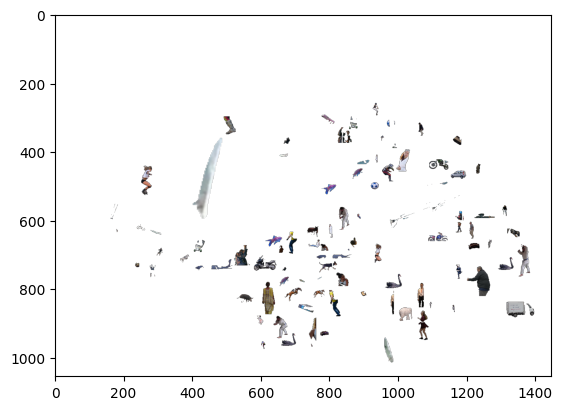

In [86]:
plt.imshow(canvas)

In [87]:
!pip install pillow


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


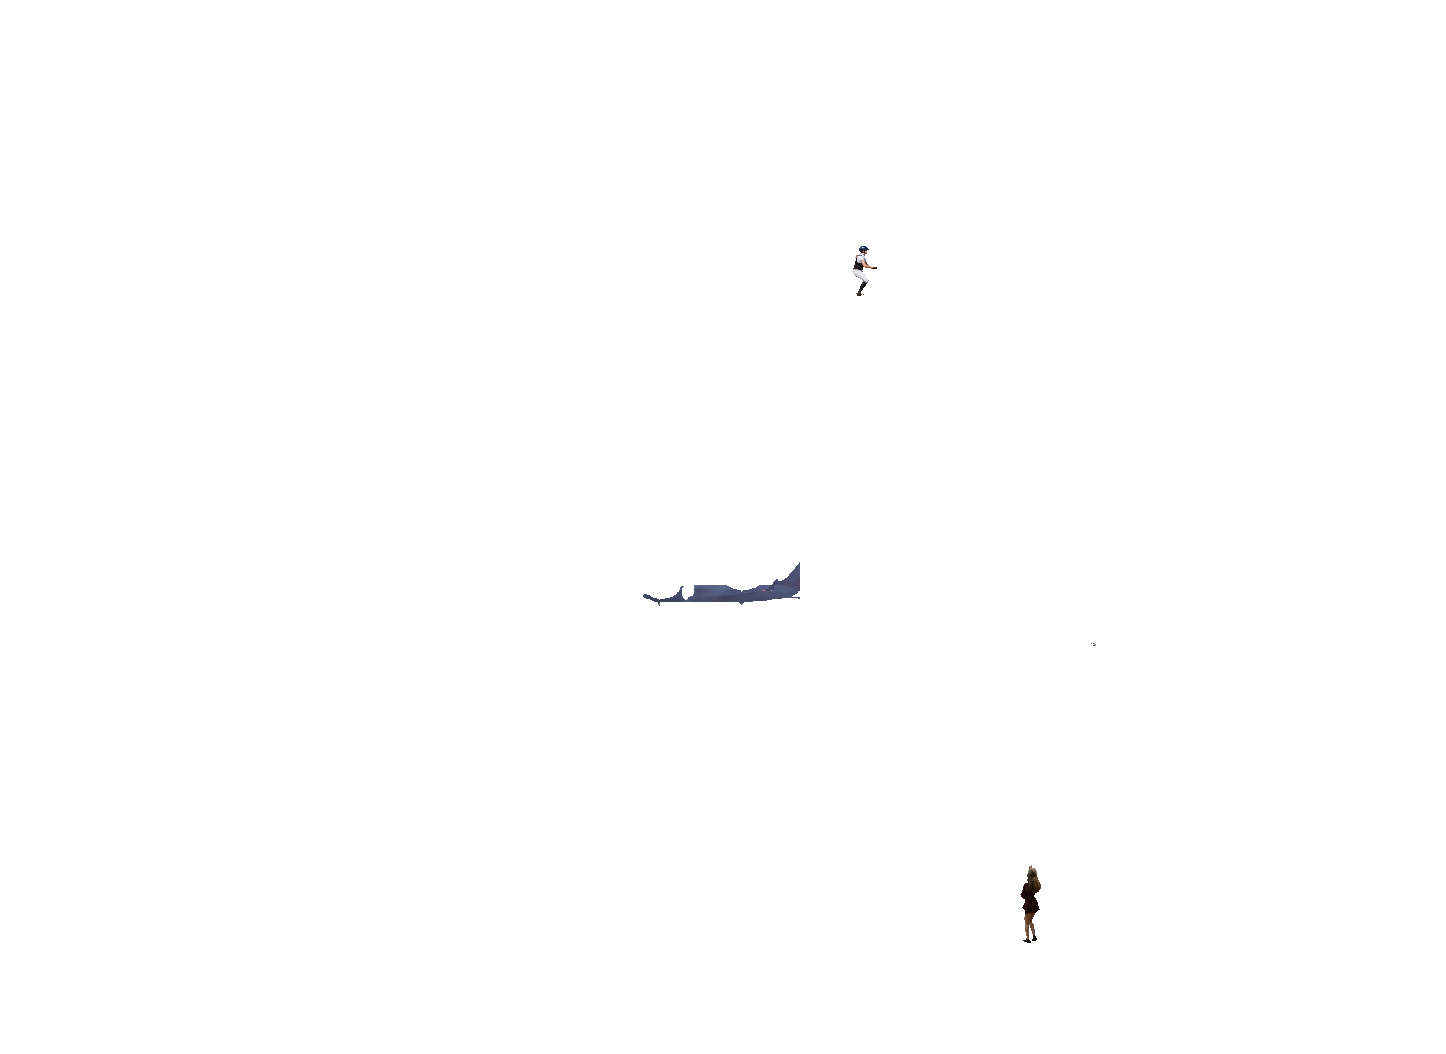

In [97]:
Image.fromarray((canvas * 255).astype(np.uint8))